In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import os


In [2]:
# 假设数据存放在 data/TRAIN/ 目录下
data_dir = 'D:/thws Mai/ann/TRAIN'
# 获取所有类别文件夹
categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

for category in categories:
    category_path = os.path.join(data_dir, category)
    # 获取该类别下的所有文件（假设每个文件都是一个 NumPy 数组）
    file_list = os.listdir(category_path)
    print(f"category '{category}' number：{len(file_list)}")


category '1' number：6000
category '2' number：6000
category '3' number：6000
category '4' number：6000
category '5' number：6000
category '6' number：6000


Category '1' sample count: 6000


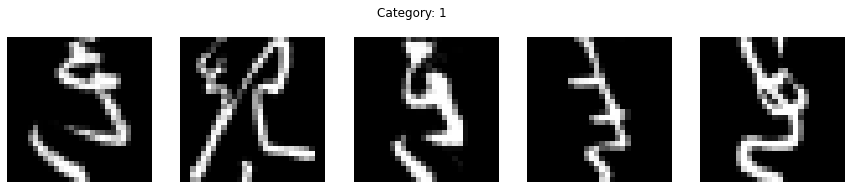

Category '2' sample count: 6000


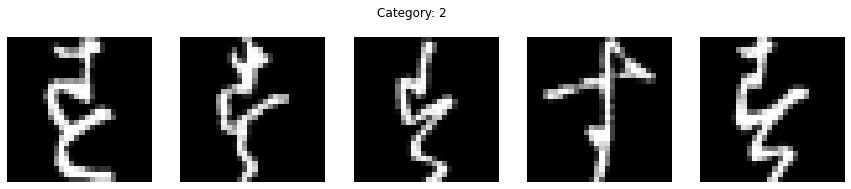

Category '3' sample count: 6000


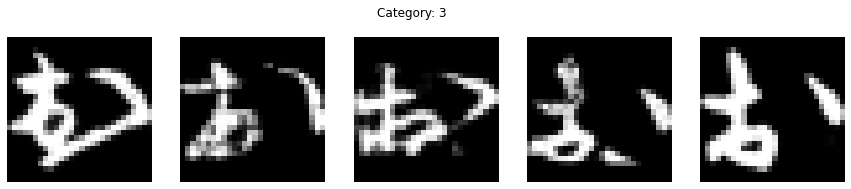

Category '4' sample count: 6000


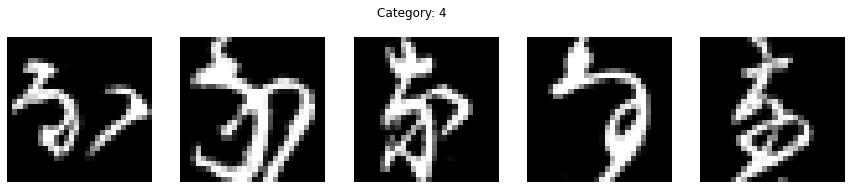

Category '5' sample count: 6000


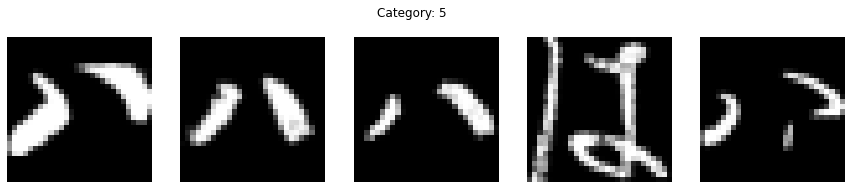

Category '6' sample count: 6000


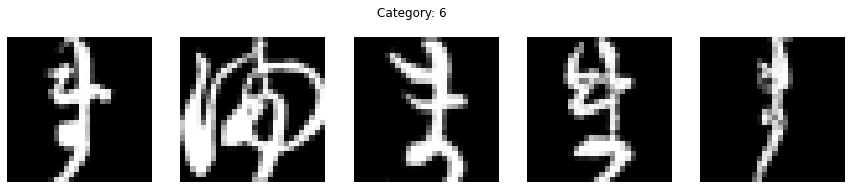

In [3]:
for category in categories:
    category_path = os.path.join(data_dir, category)
    file_list = os.listdir(category_path)  # 获取该类别下所有样本文件
    print(f"Category '{category}' sample count:", len(file_list))  # 输出该类别的样本数量

    if len(file_list) == 0:
        continue  # 若无样本则跳过

    # 如果样本不足 5 张，则显示所有样本；否则随机选择 5 张样本进行显示
    n_images = min(5, len(file_list))
    chosen_files = random.sample(file_list, n_images)

    # 创建一个图形窗口，设置适当的大小（每张图宽 3 英寸，高 3 英寸）
    plt.figure(figsize=(3 * n_images, 3))
    plt.suptitle(f"Category: {category}")  # 设置总标题为英文

    # 遍历选中的样本文件进行加载和显示
    for i, file in enumerate(chosen_files):
        sample_file = os.path.join(category_path, file)
        sample = np.load(sample_file)
        
        # 不做通道数判断，直接取第一个通道显示（假定所有图像都是灰度图）
        image = sample[0]
        
        # 使用子图显示
        plt.subplot(1, n_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')  # 关闭坐标轴显示

    plt.show()  # 显示该类别的所有图像

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN1(nn.Module):
    def __init__(self, num_classes=6):
        super(CNN1, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(10 * 14 * 14, num_classes)
    def forward(self,x):
        #print("Input shape:", x.shape)
        x = self.conv(x)
        #print("After Conv, shape:", x.shape)
        x = F.relu(x)
        x = self.pool(x)
        #print("After Pooling, shape:", x.shape)
        x = x.view(x.size(0), -1)
        #print("After Flatten, shape:", x.shape)
        x = self.fc(x)
        #print("After FC, shape:", x.shape)
        return x

如何解释这里的模型发生的变化，在卷积之后为什么从(batch_size, 1, 28, 28)变成了(batch_size, 10, 28, 28)，batch size和epoch有什么关系，这是哪里定义的呢？relu的全称是什么，说是把负的数变成零，是把哪里变成了0，如果变成零岂不是把输入图像改变了，pool操作把形状变成了(batch_size, 10, 14, 14)，这是在做什么，直接砍掉一半吗？我想象不到这个操作具体是什么样子的，然后又展平为(batch_size, 1960)，我不理解所以原来矩阵里的数据全部不见了？具体是怎么变到这个过程的呢？里面的数字是随机给的吗？还是从原来的数据经过计算变出来的？最后的线性层我也不理解。我对于整个模型的数据的形状和里面数据内容都存在很多疑惑，希望你可以耐心解答。

你还是没解释具体的怎么生成10个特征图的，计算过程是什么，每个图里面是什么，还有关键词汇你最好标注出来英文，因为我以后需要用英文和教授汇报。
展平操作我还是没理解，具体是什么操作

In [5]:
model = CNN1(num_classes=6)
print(model)
x = torch.randn(4, 1, 28, 28)  # 假设 batch_size 为 4
output = model(x)

CNN1(
  (conv): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1960, out_features=6, bias=True)
)


In [6]:
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import os
# -----------------------------
# 自定义数据集类：加载 .npy 图像和对应标签
# -----------------------------
class NumpyDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        data_dir: 数据目录，每个子文件夹为一个类别
        transform: 数据变换（本例未使用）
        """
        self.data_dir = data_dir
        self.transform = transform
        self.samples = []  # 存储 (file_path, label) 对
        # 获取类别名称列表，并按字母顺序排序
        self.classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
        # 建立类别到索引的映射，例如 {'class1': 0, 'class2': 1, ...}
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # 遍历每个类别，收集所有样本的路径和标签
        for cls in self.classes:
            cls_folder = os.path.join(data_dir, cls)
            for file in os.listdir(cls_folder):
                if file.endswith('.npy'):
                    file_path = os.path.join(cls_folder, file)
                    self.samples.append((file_path, self.class_to_idx[cls]))
                    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        file_path, label = self.samples[index]
        # 加载 .npy 文件，假定 shape 为 (C, H, W)
        image = np.load(file_path)
        # 取第一个通道作为灰度图（shape 从 (C, H, W) 变为 (H, W)）
        image = image[0]
        # 将 image 转为 float32，并归一化到 [0,1]（假设原始数据范围为 0-255）
        image = image.astype(np.float32) / 255.0
        # 转换为 tensor，并加上通道维度，最终 shape 为 (1, H, W)
        image = torch.from_numpy(image).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [7]:
# -----------------------------
# 构建数据加载器
# -----------------------------
# 根据作业要求：
# - TRAIN 用于模型训练
# - TEST 用于模型评估（请勿在训练过程中使用 TEST 数据）
train_dataset = NumpyDataset(data_dir='D:/thws Mai/ann/TRAIN')
test_dataset  = NumpyDataset(data_dir='D:/thws Mai/ann/TEST')

# 设置 DataLoader 参数
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [8]:
# 获取类别数（例如：6个类别）并实例化模型
num_classes = len(train_dataset.classes)
model = CNN1(num_classes=num_classes)
print("Model structure:")
print(model)

Model structure:
CNN1(
  (conv): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1960, out_features=6, bias=True)
)


In [9]:
criterion = nn.CrossEntropyLoss()  # 交叉熵损失，适用于多分类问题
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 使用 Adam 优化器


In [10]:
# -----------------------------
# 定义训练和评估函数
# -----------------------------
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()  # 设定模型为训练模式
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        outputs = model(inputs)          # 前向传播
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()            # 梯度清零
        loss.backward()                  # 反向传播
        optimizer.step()                 # 更新参数
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion):
    model.eval()  # 设定模型为评估模式
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # 禁用梯度计算，加快评估速度
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc

In [11]:
# -----------------------------
# 模型训练
# -----------------------------
num_epochs = 20  
train_losses = []
train_accs   = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    # 仅在训练过程中使用 TRAIN 数据，不使用 TEST 数据
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")


Epoch 1/20 - Train Loss: 1.6448, Train Acc: 0.4059
Epoch 2/20 - Train Loss: 0.9075, Train Acc: 0.7478
Epoch 3/20 - Train Loss: 0.6075, Train Acc: 0.8114
Epoch 4/20 - Train Loss: 0.5162, Train Acc: 0.8332
Epoch 5/20 - Train Loss: 0.4798, Train Acc: 0.8427
Epoch 6/20 - Train Loss: 0.4605, Train Acc: 0.8478
Epoch 7/20 - Train Loss: 0.4488, Train Acc: 0.8534
Epoch 8/20 - Train Loss: 0.4414, Train Acc: 0.8551


In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
# -----------------------------
# 在 TEST 数据集上评估模型
# -----------------------------
model.load_state_dict(torch.load('model.pth'))
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Final Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Final Test Loss: 1.9821, Test Acc: 0.4710


overfitting

In [ ]:
# -----------------------------
# 绘制训练曲线：训练损失和训练准确率
# -----------------------------
epochs = list(range(1, num_epochs+1))
plt.figure(figsize=(12, 5))

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

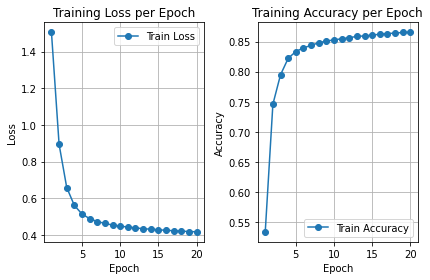

In [ ]:
# 绘制 Loss 曲线
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)

# 绘制 Accuracy 曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='Train Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
data_dir = 'D:/thws Mai/ann/TEST'
# 获取所有类别文件夹
categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

for category in categories:
    category_path = os.path.join(data_dir, category)
    # 获取该类别下的所有文件（假设每个文件都是一个 NumPy 数组）
    file_list = os.listdir(category_path)
    print(f"category '{category}' number：{len(file_list)}")

category '1' number：1000
category '2' number：1000
category '3' number：1000
category '4' number：1000
category '5' number：1000
category '6' number：1000


Category '1' sample count: 1000


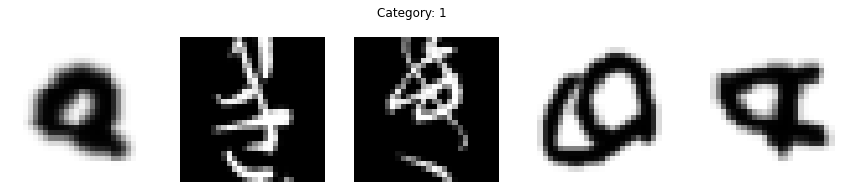

Category '2' sample count: 1000


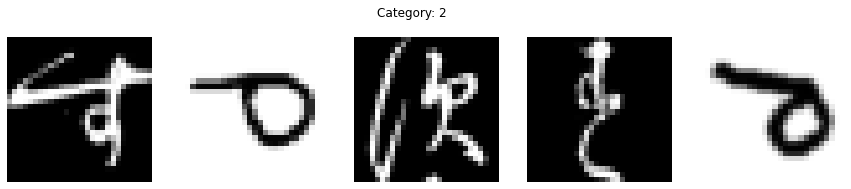

Category '3' sample count: 1000


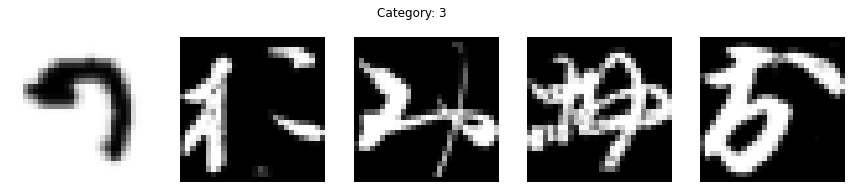

Category '4' sample count: 1000


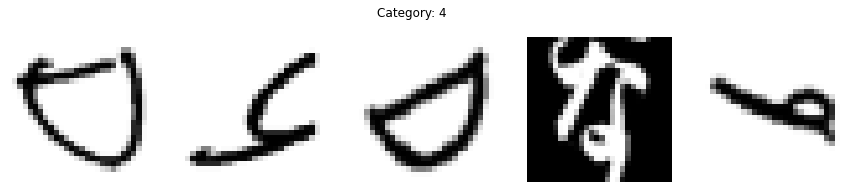

Category '5' sample count: 1000


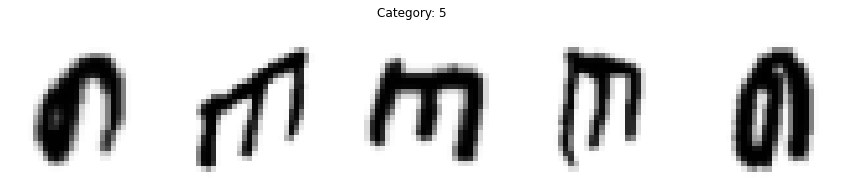

Category '6' sample count: 1000


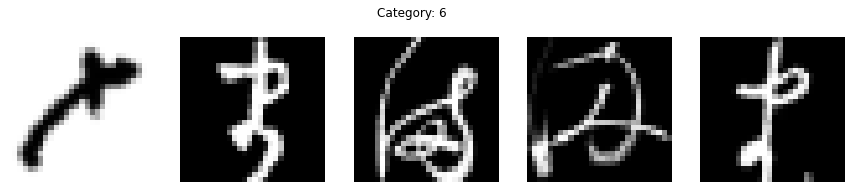

In [ ]:
for category in categories:
    category_path = os.path.join(data_dir, category)
    file_list = os.listdir(category_path)  # 获取该类别下所有样本文件
    print(f"Category '{category}' sample count:", len(file_list))  # 输出该类别的样本数量

    if len(file_list) == 0:
        continue  # 若无样本则跳过

    # 如果样本不足 5 张，则显示所有样本；否则随机选择 5 张样本进行显示
    n_images = min(5, len(file_list))
    chosen_files = random.sample(file_list, n_images)

    # 创建一个图形窗口，设置适当的大小（每张图宽 3 英寸，高 3 英寸）
    plt.figure(figsize=(3 * n_images, 3))
    plt.suptitle(f"Category: {category}")  
    # 遍历选中的样本文件进行加载和显示
    for i, file in enumerate(chosen_files):
        sample_file = os.path.join(category_path, file)
        sample = np.load(sample_file)
        
        image = sample[0]
        
        # 使用子图显示
        plt.subplot(1, n_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')  # 关闭坐标轴显示

    plt.show()  # 显示该类别的所有图像

In [ ]:
from skimage.filters import threshold_otsu

def process_train_image(image_tensor):
    return image_tensor

def process_test_image(image_tensor):
    """
    测试集预处理：  
    使用 Otsu 方法计算图像最佳阈值，并计算图像中高于该阈值像素所占比例：
      - 如果比例 > 0.5，说明大部分像素为白色，即图像为白底黑字，
        则将图像反转为黑底白字；
      - 否则，认为图像已经是黑底白字，不做处理。
    
    参数：
        image_tensor: shape (1, H, W)，已归一化到 [0,1]
    返回：
        统一为黑底白字的 image_tensor
    """
    # 去除通道维度，获得 (H, W) 的 numpy 数组
    image_np = image_tensor.squeeze().cpu().numpy()
    # 使用 Otsu 算法计算最佳阈值
    otsu_thresh = threshold_otsu(image_np)
    # 计算图像中高于阈值的像素比例
    proportion = np.mean(image_np > otsu_thresh)
    # 如果高像素比例大于 0.5，说明背景主要为白色（白底黑字）
    if proportion > 0.5:
        # 反转图像，使其变为黑底白字
        return 1.0 - image_tensor
    else:
        # 否则，直接返回
        return image_tensor


In [ ]:
class NumpyDataset(Dataset):
    def __init__(self, data_dir, mode='train', transform=None):
        """
        data_dir: 数据目录，每个子文件夹为一个类别
        mode: 'train' 或 'test'，决定采用哪种预处理函数
        transform: 其他额外变换（本例中未使用）
        """
        self.data_dir = data_dir
        self.mode = mode  # 'train' 或 'test'
        self.transform = transform
        self.samples = []  # 存储 (file_path, label) 对
        self.classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        for cls in self.classes:
            cls_folder = os.path.join(data_dir, cls)
            for file in os.listdir(cls_folder):
                if file.endswith('.npy'):
                    file_path = os.path.join(cls_folder, file)
                    self.samples.append((file_path, self.class_to_idx[cls]))
                    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        file_path, label = self.samples[index]
        # 加载 .npy 文件，假定 shape 为 (C, H, W)
        image = np.load(file_path)
        # 取第一个通道作为灰度图（将 shape 从 (C, H, W) 变为 (H, W)）
        image = image[0]
        # 转换为 float32 并归一化到 [0,1]（假设原始数据范围为 0-255）
        image = image.astype(np.float32) / 255.0
        # 转换为 tensor，并加上通道维度，最终 shape 为 (1, H, W)
        image = torch.from_numpy(image).unsqueeze(0)
        
        # 根据 mode 调用不同的预处理函数
        if self.mode == 'train':
            image = process_train_image(image)
        elif self.mode == 'test':
            image = process_test_image(image)
        else:
            # 默认不处理
            pass
        
        label = torch.tensor(label, dtype=torch.long)
        return image, label


In [ ]:
# 构建数据加载器
train_dataset = NumpyDataset(data_dir='D:/thws Mai/ann/TRAIN', mode='train')
test_dataset  = NumpyDataset(data_dir='D:/thws Mai/ann/TEST', mode='test')

# 设置 DataLoader 参数
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 后续模型训练与评估代码保持不变


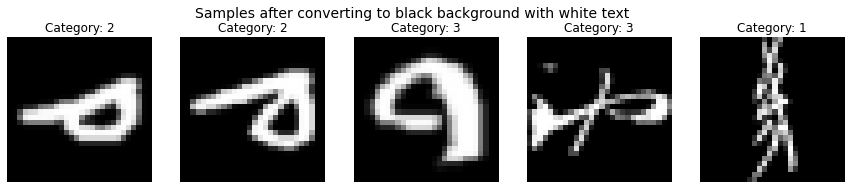

In [ ]:
# 随机选择 5 张图片进行展示
num_samples = 5
sample_indices = random.sample(range(len(test_dataset)), num_samples)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(sample_indices):
    image, label = test_dataset[idx]
    # image 的 shape 为 (1, H, W)，squeeze(0) 去掉 channel 维度
    plt.subplot(1, num_samples, i+1)
    plt.imshow(image.squeeze(0), cmap='gray')
    plt.title("Category: " + test_dataset.classes[label.item()])
    plt.axis('off')
plt.suptitle("Samples after converting to black background with white text", fontsize=14)
plt.show()

In [ ]:
# 获取类别数（例如：6个类别）并实例化模型
num_classes = len(train_dataset.classes)
model1 = CNN1(num_classes=num_classes)
print("Model structure:")
print(model1)

Model structure:
CNN1(
  (conv): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1960, out_features=6, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()  # 交叉熵损失，适用于多分类问题
optimizer = optim.Adam(model1.parameters(), lr=0.001)  # 使用 Adam 优化器

In [ ]:
# -----------------------------
# 定义训练和评估函数
# -----------------------------
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()  # 设定模型为训练模式
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        outputs = model(inputs)          # 前向传播
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()            # 梯度清零
        loss.backward()                  # 反向传播
        optimizer.step()                 # 更新参数
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion):
    model.eval()  # 设定模型为评估模式
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # 禁用梯度计算，加快评估速度
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc

In [ ]:
# -----------------------------
# 模型训练
# -----------------------------
num_epochs = 20  
train_losses = []
train_accs   = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model1, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    # 仅在训练过程中使用 TRAIN 数据，不使用 TEST 数据
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")



Epoch 1/20 - Train Loss: 1.5380, Train Acc: 0.4740
Epoch 2/20 - Train Loss: 0.8180, Train Acc: 0.7595
Epoch 3/20 - Train Loss: 0.5884, Train Acc: 0.8139
Epoch 4/20 - Train Loss: 0.5146, Train Acc: 0.8334
Epoch 5/20 - Train Loss: 0.4817, Train Acc: 0.8417
Epoch 6/20 - Train Loss: 0.4630, Train Acc: 0.8492
Epoch 7/20 - Train Loss: 0.4511, Train Acc: 0.8523
Epoch 8/20 - Train Loss: 0.4428, Train Acc: 0.8549
Epoch 9/20 - Train Loss: 0.4362, Train Acc: 0.8577
Epoch 10/20 - Train Loss: 0.4315, Train Acc: 0.8602
Epoch 11/20 - Train Loss: 0.4265, Train Acc: 0.8618
Epoch 12/20 - Train Loss: 0.4231, Train Acc: 0.8638
Epoch 13/20 - Train Loss: 0.4194, Train Acc: 0.8645
Epoch 14/20 - Train Loss: 0.4163, Train Acc: 0.8661
Epoch 15/20 - Train Loss: 0.4132, Train Acc: 0.8681
Epoch 16/20 - Train Loss: 0.4103, Train Acc: 0.8680
Epoch 17/20 - Train Loss: 0.4079, Train Acc: 0.8711
Epoch 18/20 - Train Loss: 0.4052, Train Acc: 0.8709
Epoch 19/20 - Train Loss: 0.4021, Train Acc: 0.8717
Epoch 20/20 - Train L

In [ ]:
torch.save(model.state_dict(), 'model1.pth')

In [ ]:
# -----------------------------
# 在 TEST 数据集上评估模型
# -----------------------------
test_loss, test_acc = evaluate(model1, test_loader, criterion)
print(f"Final Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Final Test Loss: 283.9802, Test Acc: 0.4725


In [ ]:
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [ ]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Final Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Final Test Loss: 240.5532, Test Acc: 0.4682
